In [5]:
!nvidia-smi

import torch

if torch.cuda.is_available():
  print('Using GPU')
  device = 'cuda'
else:
  print('CUDA not available. Please connect to a GPU instance if possible.')
  device = 'cpu'

Fri May  3 16:31:37 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  | 00000000:17:00.0 Off |                    0 |
| N/A   27C    P0              34W / 250W |     18MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

# Install prerequisites (doesn't need to be run each time)

In [6]:
%cd XMem
#!pip install opencv-python
#!pip install -U numpy
#!pip install -r requirements.txt
#!pip install imutils

/home/arm_user/XMem


# **Take photo of first frame, and generate the mask for the same**

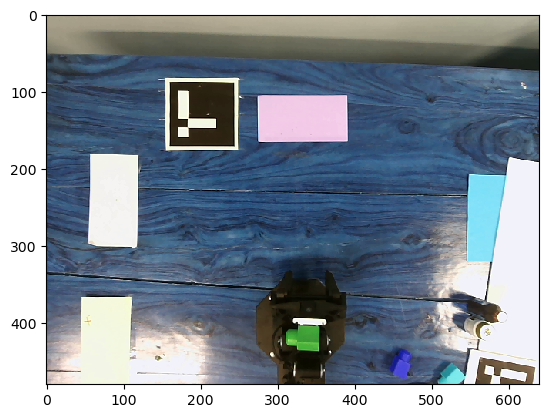

In [7]:
import imagezmq
import numpy as np
import matplotlib.pyplot as plt
import cv2
# initialize the ImageHub object
image_hub = imagezmq.ImageHub()
try:
    # receive the image from the client
    (hostname, frame) = image_hub.recv_image()
    # display the image
    cv2.imwrite('first_frame.png', frame)
    plt.imshow(frame)
    image_hub.send_reply(b'OK')
except KeyboardInterrupt:
    print("Shutting down gracefully...")
finally:
    # cleanup
    image_hub.close() # Ensure the socket is closed

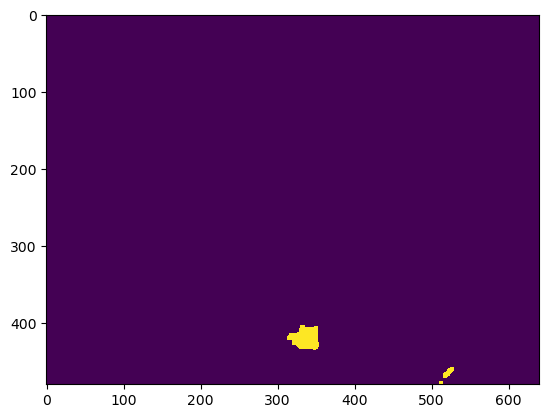

In [8]:

# import the necessary packages
import cv2
import imutils
import time
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# define the lower and upper boundaries of the "color"
# ball in the HSV color space
#colour = input("Enter a colour to track ")
#if colour == "Green" or "green":
colorLower = (37,84,142)
colorUpper=(93,255,200)
#elif colour == "Yellow" or "yellow":
  #colorLower = (54,117,118)
  #colorUpper=(84,255,255)

#elif colour == "blue" or "Blue":
#  colorLower = (0,174,220)
#  colorUpper = (60,255,255)

#elif colour == "red" or "Red":
#  colorLower = (105,146,144)
#  colorUpper = (179,255,255)
#mask_generated = False
# Open the input video file

# grab the current frame
frame = np.array(Image.open('first_frame.png'))


# resize the frame, blur it, and convert it to the HSV color space
blurred = cv2.GaussianBlur(frame, (11, 11), 0)
hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)

# construct a mask for the color "color", then perform
# a series of dilations and erosions to remove any small
# blobs left in the mask
mask = cv2.inRange(hsv, colorLower, colorUpper)
mask = cv2.erode(mask, None, iterations=2)
mask = cv2.dilate(mask, None, iterations=2)

# Threshold the mask to ensure it contains only pixel values of 0 and 255
_, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

# Save the mask with only pixel values of 0 and 1
cv2.imwrite('mask.png', mask)
plt.imshow(mask)
# close all windows
cv2.destroyAllWindows()


# **Test the live video stream code**

In [3]:
#Live video stream code
import imagezmq
import numpy as np
import matplotlib.pyplot as plt
# initialize the ImageHub object
image_hub = imagezmq.ImageHub()
try:
    while True:
        # receive the image from the client
        (hostname, frame) = image_hub.recv_image()
        # display the image
        plt.imshow(frame)
        image_hub.send_reply(b'OK')
except KeyboardInterrupt:
    print("Shutting down gracefully...")
finally:
    # cleanup
    image_hub.close() # Ensure the socket is closed

Shutting down gracefully...
Error in callback <function flush_figures at 0x7f6515125310> (for post_execute):


KeyboardInterrupt: 

# Download the pretrained model



In [6]:
#!wget -P ./saves/ https://github.com/hkchengrex/XMem/releases/download/v1.0/XMem.pth

# Basic setup

In [9]:
import os
from os import path
from argparse import ArgumentParser
import shutil

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
from PIL import Image

from inference.data.test_datasets import LongTestDataset, DAVISTestDataset, YouTubeVOSTestDataset
from inference.data.mask_mapper import MaskMapper
from model.network import XMem
from inference.inference_core import InferenceCore

from progressbar import progressbar

torch.set_grad_enabled(False)

# default configuration
config = {
    'top_k': 30,
    'mem_every': 5,
    'deep_update_every': -1,
    'enable_long_term': True,
    'enable_long_term_count_usage': True,
    'num_prototypes': 128,
    'min_mid_term_frames': 5,
    'max_mid_term_frames': 10,
    'max_long_term_elements': 10000,
}

network = XMem(config, './saves/XMem.pth').eval().to(device)

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False


# Convert the mask to a numpy array

Note that the object IDs should be consecutive and start from 1 (0 represents the background). If they are not, see `inference.data.mask_mapper` and `eval.py` on how to use it.

In [10]:
import numpy as np
from PIL import Image
mask_name = 'mask.png'
mask = np.array(Image.open(mask_name))
mask[mask == 255] =1
print(np.unique(mask))
num_objects = len(np.unique(mask)) - 1

[0 1]


# Propagte frame-by-frame

/home/arm_user/.local/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


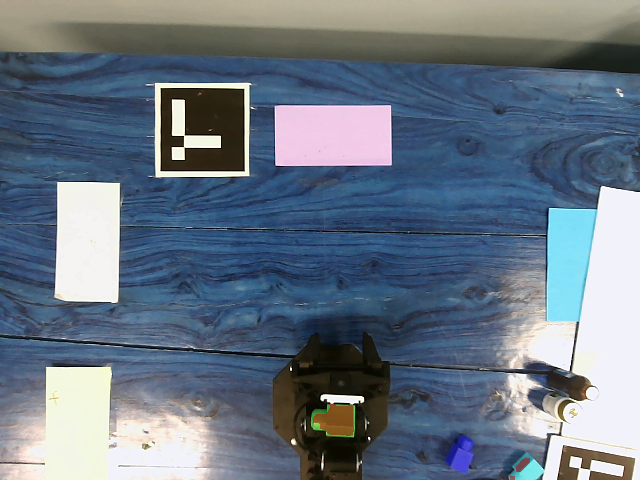

(336, 420)
(0.10094000000000002, 0.28840000000000005)
Shutting down gracefully...


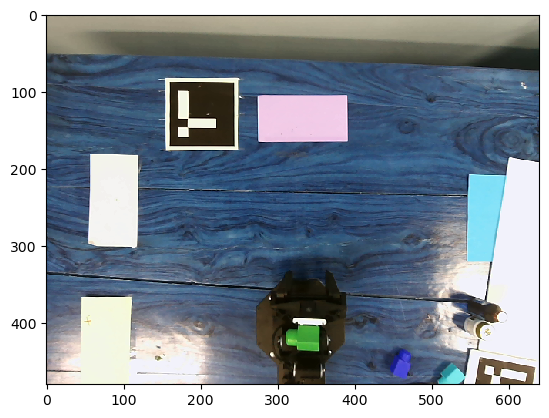

In [11]:
import cv2
from inference.interact.interactive_utils import image_to_torch, index_numpy_to_one_hot_torch, torch_prob_to_numpy_mask, overlay_davis
import imagezmq
import numpy as np
import matplotlib.pyplot as plt
torch.cuda.empty_cache()

processor = InferenceCore(network, config=config)
processor.set_all_labels(range(1, num_objects+1)) # consecutive labels

image_hub = imagezmq.ImageHub()


# You can change these two numbers
frames_to_propagate = 500
visualize_every = 10

current_frame_index = 0
try:
  with torch.cuda.amp.autocast(enabled=True):
    while (True):
      # load frame-by-frame
      # receive the image from the client
      (hostname, frame) = image_hub.recv_image()
      # display the image
      plt.imshow(frame)
      image_hub.send_reply(b'OK')
      if frame is None or current_frame_index > frames_to_propagate:
        break

      # convert numpy array to pytorch tensor format
      frame_torch, _ = image_to_torch(frame, device=device)
      if current_frame_index == 0:
        # initialize with the mask
        mask_torch = index_numpy_to_one_hot_torch(mask, num_objects+1).to(device)
        # the background mask is not fed into the model
        prediction = processor.step(frame_torch, mask_torch[1:])
      else:
        # propagate only
        prediction = processor.step(frame_torch)

      # argmax, convert to numpy
      prediction = torch_prob_to_numpy_mask(prediction)

      if current_frame_index % visualize_every == 0:
        visualization = overlay_davis(frame, prediction)
        display(Image.fromarray(visualization))
        center = None
        cnts = cv2.findContours(prediction.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        cv2.drawContours(prediction, cnts, -1, (0, 255, 0), 3)
        # only proceed if at least one contour was found
        if len(cnts) > 0:
          # find the largest contour in the mask, then use
          # it to compute the minimum enclosing circle and
          # centroid
          c = max(cnts, key=cv2.contourArea)
          ((x, y), radius) = cv2.minEnclosingCircle(c)
          M = cv2.moments(c)
          center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))
        print(center)
        xp = center[0]
        yp = center[1]
        xcm = (420-yp)*(0.00206)
        ycm = (xp-336)*(0.00206)
        center_cm = (xcm, ycm)
        print(center_cm)
        current_frame_index += 1

except KeyboardInterrupt:
    print("Shutting down gracefully...")
finally:
    # cleanup
    image_hub.close()

    # Ensure the socket is closed


/home/arm_user/.local/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


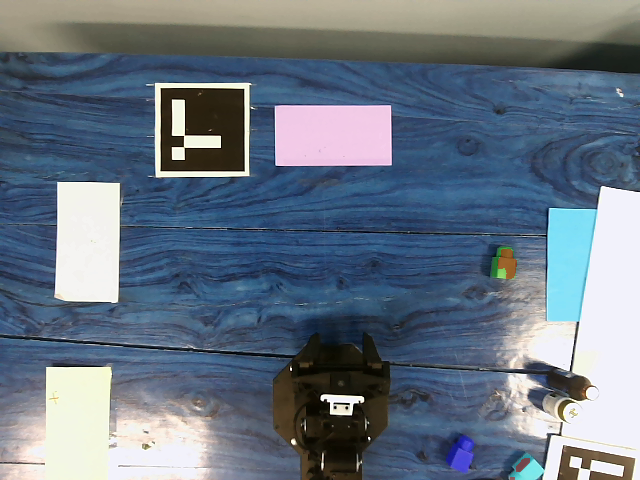

(507, 262)
(0.42642, 0.64066)
File sent
Shutting down gracefully...


In [8]:
import cv2
from inference.interact.interactive_utils import image_to_torch, index_numpy_to_one_hot_torch, torch_prob_to_numpy_mask, overlay_davis
import imagezmq
import numpy as np
import matplotlib.pyplot as plt
import os
import paramiko
client = '172.17.66.170'
username = 'alpha3'
password = 'abc123'
file1 = open('coordinates.txt', 'w')
ssh = paramiko.SSHClient() 
ssh.load_host_keys(os.path.expanduser(os.path.join("~", ".ssh", "known_hosts")))


torch.cuda.empty_cache()

processor = InferenceCore(network, config=config)
processor.set_all_labels(range(1, num_objects+1)) # consecutive labels

image_hub = imagezmq.ImageHub()


# You can change these two numbers
frames_to_propagate = 500
visualize_every = 10

current_frame_index = 0
try:
  with torch.cuda.amp.autocast(enabled=True):
    while (True):
      # load frame-by-frame
      # receive the image from the client
      (hostname, frame) = image_hub.recv_image()
      # display the image
      plt.imshow(frame)
      plt.close()
      image_hub.send_reply(b'OK')
      if frame is None or current_frame_index > frames_to_propagate:
        break

      # convert numpy array to pytorch tensor format
      frame_torch, _ = image_to_torch(frame, device=device)
      if current_frame_index == 0:
        # initialize with the mask
        mask_torch = index_numpy_to_one_hot_torch(mask, num_objects+1).to(device)
        # the background mask is not fed into the model
        prediction = processor.step(frame_torch, mask_torch[1:])
      else:
        # propagate only
        prediction = processor.step(frame_torch)

      # argmax, convert to numpy
      prediction = torch_prob_to_numpy_mask(prediction)

      if current_frame_index % visualize_every == 0:
        visualization = overlay_davis(frame, prediction)
        display(Image.fromarray(visualization))
        center = None
        cnts = cv2.findContours(prediction.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        cv2.drawContours(prediction, cnts, -1, (0, 255, 0), 3)
        # only proceed if at least one contour was found
        if len(cnts) > 0:
          # find the largest contour in the mask, then use
          # it to compute the minimum enclosing circle and
          # centroid
          c = max(cnts, key=cv2.contourArea)
          ((x, y), radius) = cv2.minEnclosingCircle(c)
          M = cv2.moments(c)
          center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))
        print(center)
        xp = center[0]
        yp = center[1]
        xcm = (469-yp)*(0.00206)
        ycm = (xp-196)*(0.00206)
        center_cm = (xcm, ycm)
        print(center_cm)
        file1 = open('coordinates.txt', 'w')
        # Writing a string to file
        file1.write(''.join(str(xcm)))
        file1.write('\n')
        file1.write(''.join(str(ycm)))
        file1.close()
        ssh.connect(client, username=username, password=password)
        sftp = ssh.open_sftp()
        sftp.put('coordinates.txt', '/home/alpha3/Desktop/Arm_project/23-24 sem2/coordinates.txt')
        print("File sent")
        sftp.close()
        ssh.close()
        current_frame_index += 1

except KeyboardInterrupt:
    print("Shutting down gracefully...")
finally:
    # cleanup
    image_hub.close()

    # Ensure the socket is closed
